<a href="https://colab.research.google.com/github/zaki391/Discovery-and-Mapping-of-global-floodplain/blob/main/Flood_risk_prediction_using_geospatial_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import fastai

fastai.__version__

'2.7.18'

In [2]:
# Install rasterio using pip
!pip install rasterio

# Import necessary libraries
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio as rio # Now this line should work

from fastai.data.all import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 76.1 MB/s eta 0:00:00


In [4]:
s1data = pd.read_csv('/content/s1_data (2).csv', dtype={'folder': 'str'})
s2data = pd.read_csv('/content/s2_data (2).csv', dtype={'folder': 'str'})


In [5]:
def open_npy(fn, chnls=None, cls=torch.Tensor):
    im = torch.from_numpy(np.load(str(fn))).type(torch.float32)
    if chnls is not None: im = im[chnls]
    return cls(im)

class MSTensorImage(TensorImage):

    def __init__(self, x, chnls_first=False):
        self.chnls_first = chnls_first

    @classmethod
    def create(cls, data:(Path,str,ndarray), chnls=None, chnls_first=True):

        if isinstance(data, Path) or isinstance(data, str):
            if str(data).endswith('npy'): im = open_npy(fn=data, chnls=chnls, cls=torch.Tensor)

        elif isinstance(data, ndarray):
            im = torch.from_numpy(data)
        else:
            im = data

        return cls(im, chnls_first=chnls_first)


    def show(self, chnls=[0, 1, 2], bright=2., ctx=None):
#         pdb.set_trace()
        if self.ndim > 2:
            visu_img = self[..., chnls] if not self.chnls_first else self.permute([1, 2, 0])[..., chnls]
        else:
            visu_img = self

        visu_img = visu_img.squeeze()

        visu_img *= bright
        visu_img = np.where(visu_img > 1, 1, visu_img)
        visu_img = np.where(visu_img < 0, 0, visu_img)

        plt.imshow(visu_img) if ctx is None else ctx.imshow(visu_img)

        return ctx

    def __repr__(self):

        return (f'MSTensorImage: {self.shape}')

In [6]:
def get_x(row):
    path = root/str(row['folder'])/row['filename']
    return path

def get_y(row):
    label = row['FLOODING']
    return 'Flood' if label else 'No Flood'

In [7]:
import pdb
# Create a block that loads the S2 Image given the path/base_filename
# First, let's create a function to load the desired bands into an xarray Dataset
# This function is slightly different from the one on the previous notebook, as we will not use rioxarray
# We will use rasterio for performance purposes here
class MSImageTensor(Tensor):

    def show(self, ctx: plt.Axes, *args, **kwargs):
        pdb.set_trace()

        ax = ctx
        if ax is None: _, ax = plt.subplots()
        ax.imshow(self.permute((1, 2, 0)))

    def __repr__(self):
        return f'MSImageTensor: {self.data.shape}'

def load_img(path: Path, bands=['B04', 'B03', 'B02']):

    # get the files paths
    files = [path.with_name(path.name+f'_{b}.tif') for b in bands]

    # Open each file with rasterio and save them to a list
    arrays = [rio.open(f).read().squeeze() for f in files]

    # stack the layers on the first axis (dimension)
    img = np.stack(arrays, axis=0)

    # convert to an DataArray creating a band dimension
    return MSTensorImage.create(img * 1e-4)
#     return MSImageTensor(img * 1e-4)

In [8]:
pip install fastai


In [9]:
!unzip '/content/Flood image-20241227T162149Z-001.zip' -d '/content/flood_images' # Extract the zip file to a new directory

from fastai.vision.all import *

# Define the path to your extracted image folder
path = Path('/content/flood_images/Flood image') # Update path to point to the extracted folder

# Check if the path exists and has subdirectories
if path.exists() and any(path.iterdir()):
    print("Path is valid and contains files!")
else:
    print("Path is invalid or empty.")

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Image input and categorical output
    get_items=get_image_files,  # Get image files from the folder
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Split the data into train/validation sets (80-20%)
    get_y=parent_label,  # Get labels from the folder names (e.g., 'cat' or 'dog')
    item_tfms=Resize(128),  # Resize images to 128x128
)

# Create the dataset from the images
s2ds = dblock.datasets(path)

# If the dataset is created successfully, view the first item from the training set
print(s2ds.train[0])

Archive:  /content/Flood image-20241227T162149Z-001.zip
  inflating: /content/flood_images/Flood image/S2_2019-03-28_B08.tif  
  inflating: /content/flood_images/Flood image/S2_2019-03-28_B07.tif  
  inflating: /content/flood_images/Flood image/S2_2019-04-27_B07.tif  
  inflating: /content/flood_images/Flood image/S2_2019-04-24_B8A.tif  
  inflating: /content/flood_images/Flood image/S2_2019-03-28_B06.tif  
  inflating: /content/flood_images/Flood image/S2_2019-04-24_B11.tif  
  inflating: /content/flood_images/Flood image/S2_2019-04-24_B05.tif  
  inflating: /content/flood_images/Flood image/S2_2019-03-28_B11.tif  
  inflating: /content/flood_images/Flood image/S2_2019-04-24_B02.tif  
  inflating: /content/flood_images/Flood image/S2_2019-03-28_B12.tif  
  inflating: /content/flood_images/Flood image/S2_2019-03-28_B8A.tif  
  inflating: /content/flood_images/Flood image/S2_2019-04-27_B03.tif  
  inflating: /content/flood_images/Flood image/S2_2019-04-24_B12.tif  
  inflating: /content

In [10]:
S2Block = TransformBlock(type_tfms=load_img, batch_tfms=ToTensor)

In [11]:
s2ds.vocab

['Flood image']

In [12]:
x = s2ds.train[0][0]

In [13]:
ImageBlock??

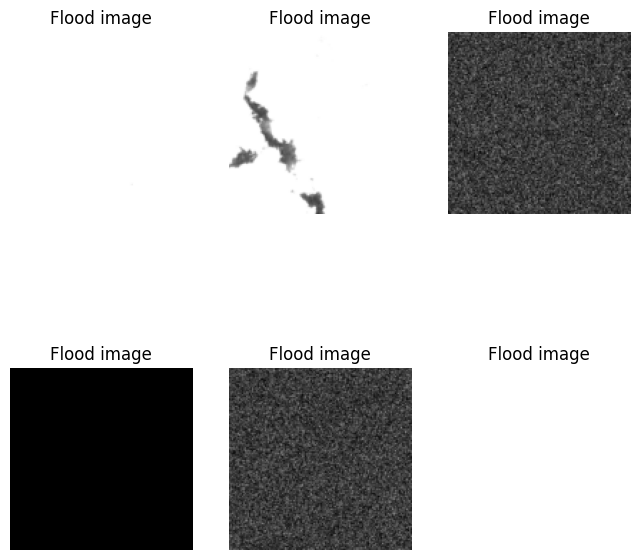

In [14]:
from fastai.vision.all import *

# Define the path to your extracted image folder
path = Path('/content/flood_images/Flood image')  # Update path to the extracted image folder

# Define the DataBlock for image classification
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Image input and categorical output
    get_items=get_image_files,  # Get image files from the folder
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Split the data into train/validation sets
    get_y=parent_label,  # Get labels from the folder names (e.g., 'cat' or 'dog')
    item_tfms=Resize(128),  # Resize images to 128x128
)

# Create the dataset from the images
s2ds = dblock.datasets(path)  # Use the corrected path here

# Create a DataLoader from the training dataset
dls = dblock.dataloaders(path)  # Use the corrected path here

# Show a batch of images from the training dataset
dls.train.show_batch(max_n=6, figsize=(8, 8))

In [15]:
def get_x(row):
    path = root/str(row['folder'])/row['filename']
    return path

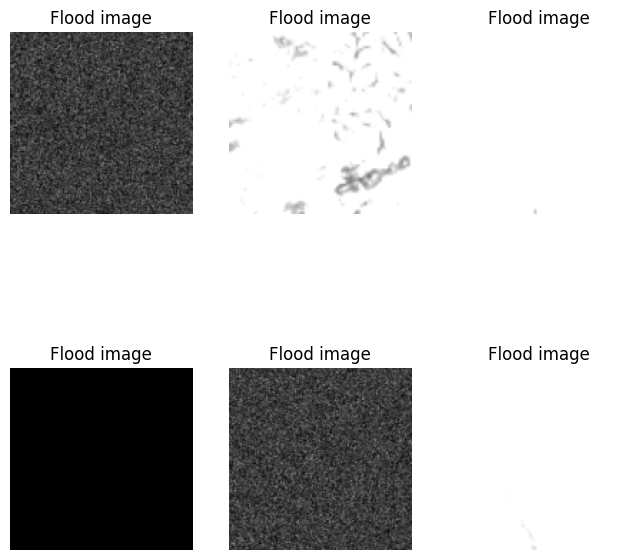

In [16]:
dls.valid.show_batch(max_n=6, figsize=(8, 8))


<Axes: title={'center': 'TensorCategory(0)'}>

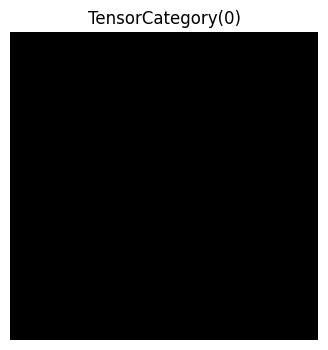

In [17]:
# Get a single batch of data
batch = dls.train.one_batch()

# Access the first image and label from the batch
img, label = batch[0][0], batch[1][0]

# Display the image along with its label
img.show(title=label)

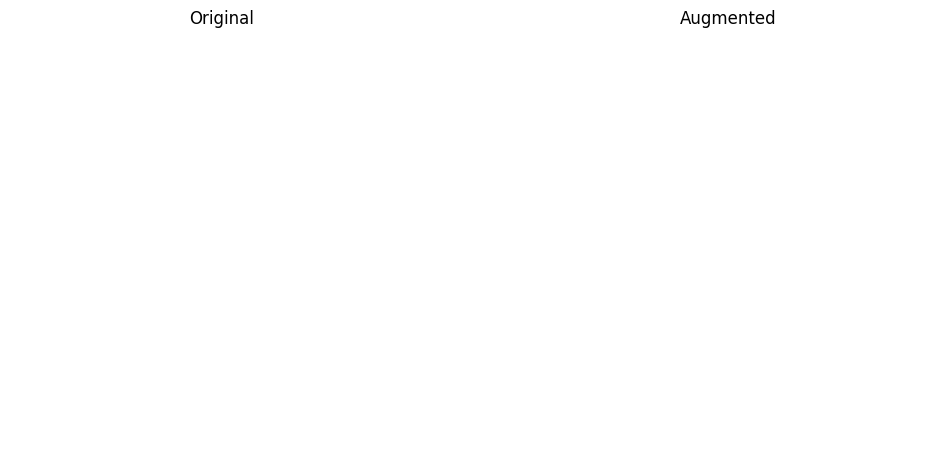

In [18]:
# Define a custom transformation to augment the data
item_tfms = [Resize(128), FlipItem(p=0.5)]  # Resize and flip images randomly

# Get a single item from the training dataset using the `one_batch()` method
batch = dls.train.one_batch()
img, label = batch[0][0], batch[1][0] # Access the image and label from the batch


# Apply the transformation to the first image
augmented_img = item_tfms[1](img)

# Show original vs augmented image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img.permute(1, 2, 0))
axes[0].set_title("Original")
axes[0].axis('off')
axes[1].imshow(augmented_img.permute(1, 2, 0))
axes[1].set_title("Augmented")
axes[1].axis('off')
plt.show()

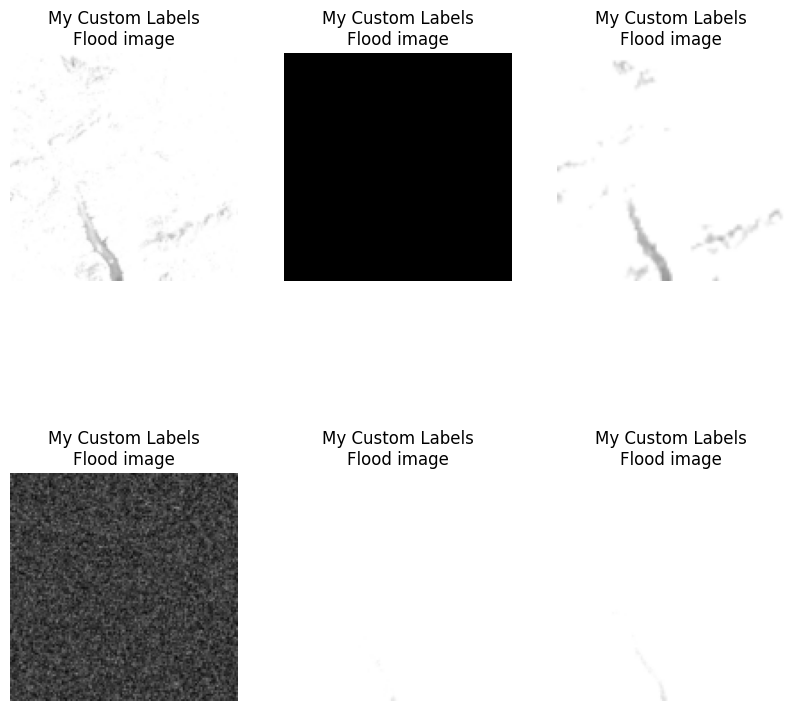

In [19]:
# Show a batch of images with custom labels
dls.train.show_batch(max_n=6, figsize=(10, 10), title="My Custom Labels")


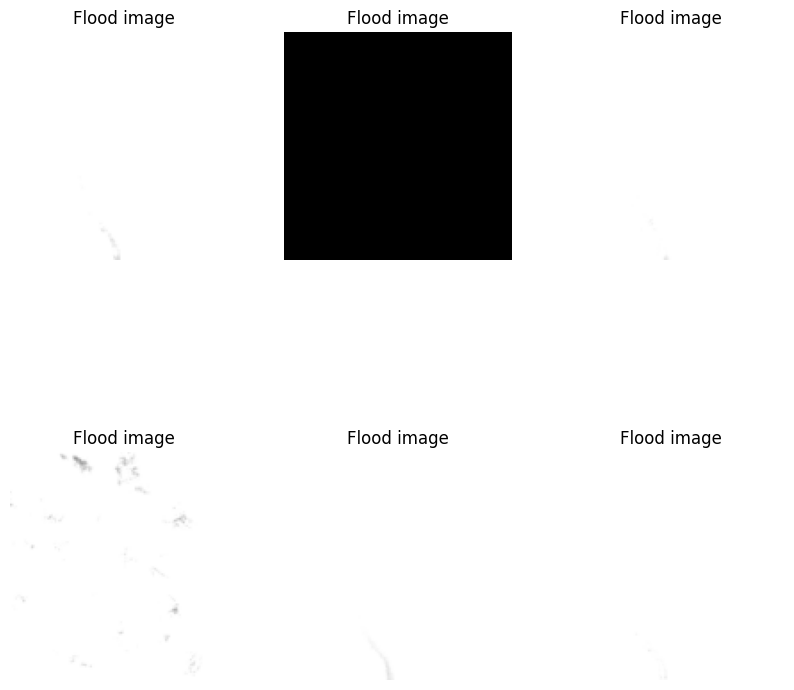

In [20]:
# Create a DataLoader with augmentation transformations
aug_dls = dblock.dataloaders(path, item_tfms=Resize(128), batch_tfms=aug_transforms())

# Show a batch with augmentation transformations
aug_dls.train.show_batch(max_n=6, figsize=(10, 10))


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:09
1,0.000000,0.000000,0.000000,00:08
2,0.000000,0.000000,0.000000,00:09
3,0.000000,0.000000,0.000000,00:09
4,0.000000,0.000000,0.000000,00:07


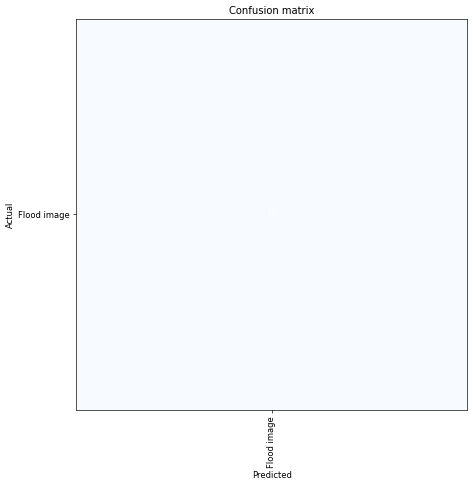

In [21]:
# Assuming you have trained a model
# First, create a learner object
# Example using resnet18 and the dataloaders created earlier
learn = cnn_learner(dls, resnet18, metrics=error_rate)

# Train the model (e.g., for 5 epochs)
learn.fine_tune(5)

# Now, get the model's predictions on the validation set
interp = ClassificationInterpretation.from_learner(learn)

# Plot the confusion matrix
interp.plot_confusion_matrix(figsize=(8, 8), dpi=60)

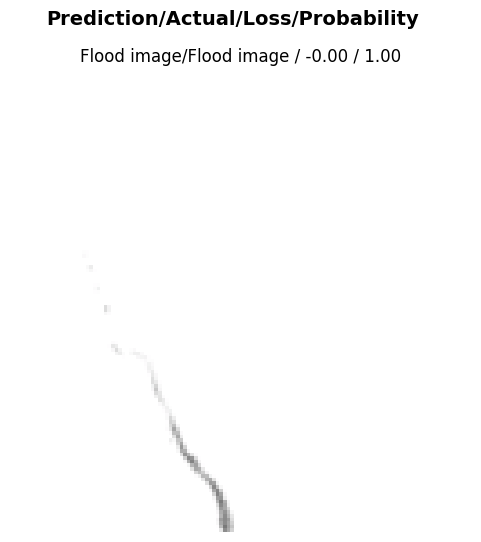

In [22]:
# Assuming you have trained a model `learn`

# Get a single batch of data (containing one or more images)
batch = dls.train.one_batch()

# Access the first image and label from the batch
img, label = batch[0][0], batch[1][0]  # Assuming the batch structure

# Now you can use `img` and `label`
# learn.show_cam(img) # This line was causing the error

# Instead, use `ClassificationInterpretation` for visualization:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(k=1, figsize=(7,6)) # Show top losses

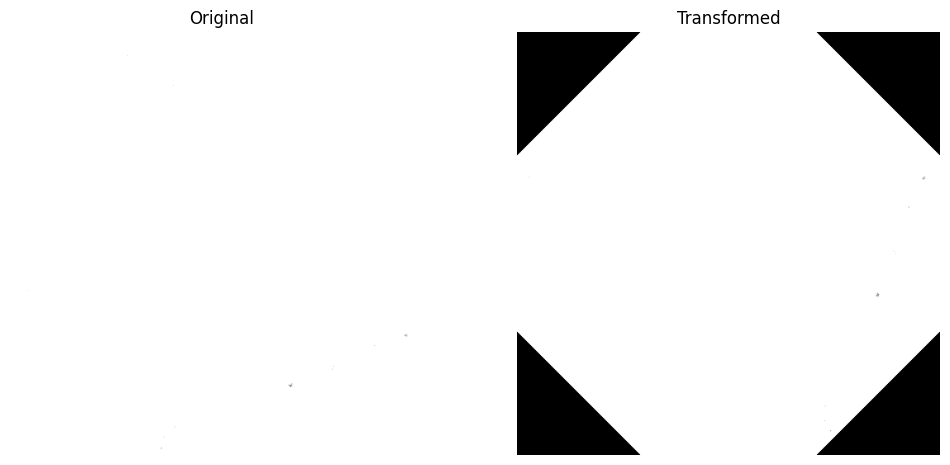

In [23]:
from fastai.vision.all import *

# Define a custom transform (e.g., crop, rotate)
def my_custom_tfms(x):
    return x.rotate(45)  # Rotate the image by 45 degrees

# Instead of directly indexing the DataLoader, use `dls.train.dataset` to access the underlying dataset
img, label = dls.train.dataset[0]  # Get the first image and label from the training dataset

transformed_img = my_custom_tfms(img)

# Show original vs transformed image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Convert the PILImage to a NumPy array and then display
# The 'to_rgb' method is used to convert to RGB format if necessary
axes[0].imshow(np.array(img.convert('RGB'))) # Convert to NumPy array for display
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(np.array(transformed_img.convert('RGB'))) # Convert to NumPy array for display
axes[1].set_title("Transformed")
axes[1].axis('off')
plt.show()

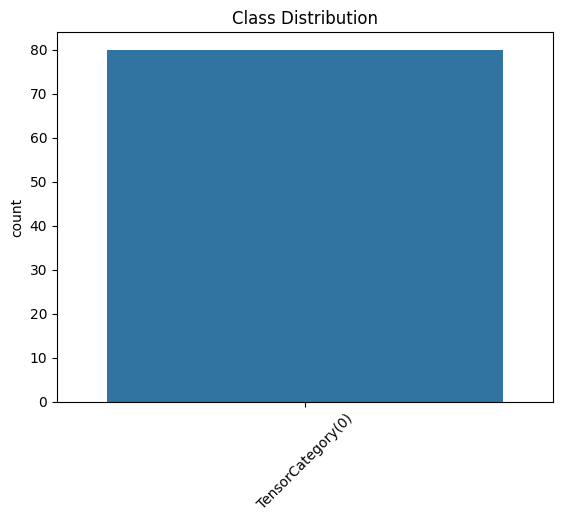

In [24]:
import seaborn as sns

# Get the labels of the training dataset
labels = [label for _, label in s2ds.train]

# Create a count plot to visualize the class distribution
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()


CNN **model**

In [25]:
pip install tensorflow pandas numpy matplotlib scikit-learn

In [31]:
import pandas as pd

df = pd.read_csv('/content/s1_data (2).csv')
df = pd.read_csv('/content/s2_data (2).csv')
print(df.head())

                                                                                                                          geometry  \
0       [[[48.747512, 30.683485], [48.748582, 30.637319], [48.801973, 30.638233], [48.800927, 30.684401], [48.747512, 30.683485]]]   
1  [[[34.810117, -19.588125], [34.810635, -19.634372], [34.859444, -19.633874], [34.858912, -19.587629], [34.810117, -19.588125]]]   
2       [[[48.746053, 31.442841], [48.747157, 31.396681], [48.800973, 31.397615], [48.799895, 31.443777], [48.746053, 31.442841]]]   
3  [[[18.682633, -33.850628], [18.681385, -33.896767], [18.736717, -33.897797], [18.737935, -33.851655], [18.682633, -33.850628]]]   
4  [[[32.622722, -19.901449], [32.622612, -19.947716], [32.671541, -19.947814], [32.671636, -19.901546], [32.622722, -19.901449]]]   

   label        date  tile_number                                     id  \
0      1  2019-04-23          -12  sen12floods_s2_labels_0244_2019_04_23   
1      0  2019-01-26           11    sen12f

In [44]:
df.head(10)

,geometry,label,date,tile_number,id,location_id,image_dir
0,"[[[48.747512, 30.683485], [48.748582, 30.637319], [48.801973, 30.638233], [48.800927, 30.684401], [48.747512, 30.683485]]]",1,2019-04-23,-12,sen12floods_s2_labels_0244_2019_04_23,244,../input/sen12flood/sen12flood/sen12floods_s2_source/sen12floods_s2_source//sen12floods_s2_source_0244_2019_04_23
1,"[[[34.810117, -19.588125], [34.810635, -19.634372], [34.859444, -19.633874], [34.858912, -19.587629], [34.810117, -19.588125]]]",0,2019-01-26,11,sen12floods_s2_labels_11_2019_01_26,11,../input/sen12flood/sen12flood/sen12floods_s2_source/sen12floods_s2_source//sen12floods_s2_source_11_2019_01_26
2,"[[[48.746053, 31.442841], [48.747157, 31.396681], [48.800973, 31.397615], [48.799895, 31.443777], [48.746053, 31.442841]]]",0,2019-03-04,31,sen12floods_s2_labels_0287_2019_03_04,287,../input/sen12flood/sen12flood/sen12floods_s2_source/sen12floods_s2_source//sen12floods_s2_source_0287_2019_03_04
3,"[[[18.682633, -33.850628], [18.681385, -33.896767], [18.736717, -33.897797], [18.737935, -33.851655], [18.682633, -33.850628]]]",0,2018-12-20,5,sen12floods_s2_labels_0005_2018_12_20,5,../input/sen12flood/sen12flood/sen12floods_s2_source/sen12floods_s2_source//sen12floods_s2_source_0005_2018_12_20
4,"[[[32.622722, -19.901449], [32.622612, -19.947716], [32.671541, -19.947814], [32.671636, -19.901546], [32.622722, -19.901449]]]",0,2019-03-10,21,sen12floods_s2_labels_21_2019_03_10,21,../input/sen12flood/sen12flood/sen12floods_s2_source/sen12floods_s2_source//sen12floods_s2_source_21_2019_03_10
5,"[[[34.712523, -19.589079], [34.713013, -19.635328], [34.761825, -19.634857], [34.761321, -19.588609], [34.712523, -19.589079]]]",0,2019-01-31,-116,sen12floods_s2_labels_0140_2019_01_31,140,../input/sen12flood/sen12flood/sen12floods_s2_source/sen12floods_s2_source//sen12floods_s2_source_0140_2019_01_31
6,"[[[48.638378, 31.4409], [48.639534, 31.394743], [48.693345, 31.395723], [48.692214, 31.441882], [48.638378, 31.4409]]]",0,2019-03-12,29,sen12floods_s2_labels_0285_2019_03_12,285,../input/sen12flood/sen12flood/sen12floods_s2_source/sen12floods_s2_source//sen12floods_s2_source_0285_2019_03_12
7,"[[[48.528285, 31.531174], [48.5295, 31.485022], [48.583358, 31.48605], [48.582169, 31.532204], [48.528285, 31.531174]]]",0,2019-03-09,15,sen12floods_s2_labels_0271_2019_03_09,271,../input/sen12flood/sen12flood/sen12floods_s2_source/sen12floods_s2_source//sen12floods_s2_source_0271_2019_03_09
8,"[[[-1.641771, 6.684691], [-1.641898, 6.638389], [-1.595591, 6.63826], [-1.59546, 6.684562], [-1.641771, 6.684691]]]",0,2019-01-02,107,sen12floods_s2_labels_0107_2019_01_02,107,../input/sen12flood/sen12flood/sen12floods_s2_source/sen12floods_s2_source//sen12floods_s2_source_0107_2019_01_02
9,"[[[36.749275, -1.195757], [36.749236, -1.242043], [36.795224, -1.242082], [36.795262, -1.195795], [36.749275, -1.195757]]]",0,2019-02-08,9,sen12floods_s2_labels_0009_2019_02_08,9,../input/sen12flood/sen12flood/sen12floods_s2_source/sen12floods_s2_source//sen12floods_s2_source_0009_2019_02_08


In [32]:
from sklearn.model_selection import train_test_split

# Splitting the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [34]:
# Reshape for CNN input: Ensure sufficient timesteps (e.g., duplicate columns if necessary)
X_train = np.expand_dims(X_train, axis=2)  # Shape: (samples, timesteps, features)
X_test = np.expand_dims(X_test, axis=2)

# Build CNN model with adjusted architecture
cnn_model = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train CNN model
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate CNN
cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"CNN Accuracy: {cnn_accuracy * 100:.2f}%")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0064 - loss: 5.3503 - val_accuracy: 0.0056 - val_loss: 5.0304
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0176 - loss: 4.7833 - val_accuracy: 0.0146 - val_loss: 4.5854
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0335 - loss: 4.3465 - val_accuracy: 0.0202 - val_loss: 4.3346
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0387 - loss: 4.0785 - val_accuracy: 0.0224 - val_loss: 4.1219
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0500 - loss: 3.8996 - val_accuracy: 0.0348 - val_loss: 3.9628
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0638 - loss: 3.7625 - val_accuracy: 0.0494 - val_loss: 3.8301
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0588 - loss: 3.6474 - val_accuracy: 0.0438 - val_loss: 3.7423
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0702 - loss: 3.5529 - val_accuracy: 0.0471 - val_

In [52]:
cnn_model = Sequential([
    Conv1D(64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=1),
    Dropout(0.25),

    Conv1D(128, kernel_size=1, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=1),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9456 - loss: 0.1185 - val_accuracy: 1.0000 - val_loss: 0.0605
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 1.8479e-04
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 8.4354e-04 - val_accuracy: 1.0000 - val_loss: 9.3896e-06
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 2.2551e-04 - val_accuracy: 1.0000 - val_loss: 1.7516e-06
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 2.9058e-04 - val_accuracy: 1.0000 - val_loss: 5.8200e-07
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.3279e-04 - val_accuracy: 1.0000 - val_loss: 3.2485e-07
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.00

In [53]:
### Feature Select - F regression
def select_features(X_data, y_data, X_test,k='all'):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k=k)
    fs.fit(X_data, y_data)
    # transform train input data
    X_data_fs = fs.transform(X_data)
    # transform test input data
    X_test_fs = fs.transform(X_data)
    return X_train_fs, X_test_fs, fs

In [54]:
geometry = np.random.choice(1000, replace=False, size=50)
data_trimmed = data.iloc[geometry]

In [55]:
X = data_trimmed.drop(labels=['geometry'],axis =1).values
y = data_trimmed['geometry'].values
X_test = data.values

In [56]:
from sklearn.feature_selection import f_regression, SelectKBest

def select_features(X_data, y_data, X_test, k='all'):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k=k)
    fs.fit(X_data, y_data)
    # transform train input data
    X_data_fs = fs.transform(X_data)
    # transform test input data
    return X_train_fs,
    fs.transform(X_data), fs
    plt.show()

In [57]:
X_data, X_val, y_data, y_val = train_test_split(X, y, test_size=0.25)

In [59]:
!pip install catboost
from catboost import CatBoostRegressor
model=CatBoostRegressor(iterations=100, depth=10, learning_rate=0.01, loss_function='RMSE')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [60]:

import pandas as pd

# Convert y_data to a Pandas Series
y_data = pd.Series(y_data)

# Convert non-numeric values to NaN
y_data = y_data.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Drop any rows with NaN values
y_data = y_data.dropna()
plt.show()

In [61]:
years= np.sort(data['date'].unique())[::-1]

In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [67]:
# Train Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
import pandas as pd

# Load the data
s1data = pd.read_csv('/content/s1_data (2).csv', dtype={'folder': 'str'})

# Print the column names to verify
print(s1data.columns)

# Adjust column names or handle extra spaces/characters if necessary
# For example, if your columns are named 'vv' and 'vh':
# X = s1data[['vv', 'vh']]

# Or, to remove leading/trailing spaces from all column names:
# s1data.columns = s1data.columns.str.strip()
# X = s1data[['VV', 'VH']]

# If using a different delimiter:
# s1data = pd.read_csv('/content/s1_data (2).csv', delimiter=';', dtype={'folder': 'str'})
# X = s1data[['VV', 'VH']]

# ... (Rest of your code) ...

Index(['geometry', 'label', 'date', 'tile_number', 'id', 'location_id',
       'image_dir'],
      dtype='object')


In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:

flood = pd.read_csv('/content/s1_data (2).csv')
flood.head(10)

,geometry,label,date,tile_number,id,location_id,image_dir
0,"[[[36.801563, -17.829673], [36.802546, -17.875849], [36.850768, -17.874901], [36.849773, -17.828728], [36.801563, -17.829673]]]",0,2019-02-06,-91,sen12floods_s1_labels_0165_2019_02_06,165,../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0165_2019_02_06
1,"[[[30.079766, -1.947669], [30.079851, -1.993923], [30.125823, -1.993836], [30.125737, -1.947584], [30.079766, -1.947669]]]",0,2018-12-19,26,sen12floods_s1_labels_0026_2018_12_19,26,../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0026_2018_12_19
2,"[[[-1.734277, 6.731243], [-1.734397, 6.684938], [-1.688083, 6.684817], [-1.687959, 6.731121], [-1.734277, 6.731243]]]",0,2018-12-17,100,sen12floods_s1_labels_0100_2018_12_17,100,../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0100_2018_12_17
3,"[[[146.754028, -19.184316], [146.753959, -19.230587], [146.802672, -19.230646], [146.802727, -19.184374], [146.754028, -19.184316]]]",1,2019-02-11,49,sen12floods_s1_labels_0305_2019_02_11,305,../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0305_2019_02_11
4,"[[[48.748582, 30.637319], [48.749651, 30.591154], [48.803016, 30.592066], [48.801973, 30.638233], [48.748582, 30.637319]]]",0,2019-04-06,-10,sen12floods_s1_labels_0246_2019_04_06,246,../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0246_2019_04_06
5,"[[[48.582169, 31.532204], [48.583358, 31.48605], [48.637218, 31.487056], [48.636056, 31.533212], [48.582169, 31.532204]]]",0,2019-03-09,16,sen12floods_s1_labels_0272_2019_03_09,272,../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0272_2019_03_09
6,"[[[32.797613, -19.779918], [32.797555, -19.826187], [32.846447, -19.826235], [32.846492, -19.779967], [32.797613, -19.779918]]]",0,2019-02-28,-42,sen12floods_s1_labels_0214_2019_02_28,214,../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0214_2019_02_28
7,"[[[146.851344, -19.276963], [146.851302, -19.323235], [146.900043, -19.323268], [146.900071, -19.276997], [146.851344, -19.276963]]]",1,2019-03-07,65,sen12floods_s1_labels_0321_2019_03_07,321,../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0321_2019_03_07
8,"[[[34.858912, -19.587629], [34.859444, -19.633874], [34.908251, -19.633363], [34.907706, -19.587119], [34.858912, -19.587629]]]",0,2019-02-06,-113,sen12floods_s1_labels_0143_2019_02_06,143,../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0143_2019_02_06
9,"[[[146.802617, -19.276917], [146.802561, -19.323189], [146.851302, -19.323235], [146.851344, -19.276963], [146.802617, -19.276917]]]",1,2019-02-23,64,sen12floods_s1_labels_0320_2019_02_23,320,../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0320_2019_02_23


In [82]:
flood.info

<bound method DataFrame.info of                                                                                                                                   geometry  \
0          [[[36.801563, -17.829673], [36.802546, -17.875849], [36.850768, -17.874901], [36.849773, -17.828728], [36.801563, -17.829673]]]   
1               [[[30.079766, -1.947669], [30.079851, -1.993923], [30.125823, -1.993836], [30.125737, -1.947584], [30.079766, -1.947669]]]   
2                    [[[-1.734277, 6.731243], [-1.734397, 6.684938], [-1.688083, 6.684817], [-1.687959, 6.731121], [-1.734277, 6.731243]]]   
3     [[[146.754028, -19.184316], [146.753959, -19.230587], [146.802672, -19.230646], [146.802727, -19.184374], [146.754028, -19.184316]]]   
4               [[[48.748582, 30.637319], [48.749651, 30.591154], [48.803016, 30.592066], [48.801973, 30.638233], [48.748582, 30.637319]]]   
...                                                                                                                                    ...   
3326         [[[32.557683, -25.909985], [32.55751, -25.956217], [32.60865, -25.956364], [32.608803, -25.910132], [32.557683, -25.909985]]]   
3327     [[[146.802506, -19.369459], [146.80245, -19.41573], [146.851218, -19.415777], [146.85126, -19.369506], [146.802506, -19.369459]]]   
3328       [[[36.801563, -17.829673], [36.802546, -17.875849], [36.850768, -17.874901], [36.849773, -17.828728], [36.801563, -17.829673]]]   
3329         [[[32.558027, -25.81752], [32.557855, -25.863753], [32.608955, -25.863899], [32.609107, -25.817666], [32.558027, -25.81752]]]   
3330       [[[38.062841, -17.277357], [38.062607, -17.323632], [38.110785, -17.323851], [38.111007, -17.277576], [38.062841, -17.277357]]]   

      label        date  tile_number                                     id  \
0         0  2019-02-06          -91  sen12floods_s1_labels_0165_2019_02_06   
1         0  2018-12-19           26  sen12floods_s1_labels_0026_2018_12_19   
2         0  2018-12-17          100  sen12floods_s1_labels_0100_2018_12_17   
3         1  2019-02-11           49  sen12floods_s1_labels_0305_2019_02_11   
4         0  2019-04-06          -10  sen12floods_s1_labels_0246_2019_04_06   
...     ...         ...          ...                                    ...   
3326      0  2018-12-24          125  sen12floods_s1_labels_0125_2018_12_24   
3327      1  2019-02-23           78  sen12floods_s1_labels_0334_2019_02_23   
3328      0  2019-03-09          -91  sen12floods_s1_labels_0165_2019_03_09   
3329      0  2018-12-29          121  sen12floods_s1_labels_0121_2018_12_29   
3330      1  2019-04-14          -80  sen12floods_s1_labels_0176_2019_04_14   

      location_id  \
0             165   
1              26   
2             100   
3             305   
4             246   
...           ...   
3326          125   
3327          334   
3328          165   
3329          121   
3330          176   

                                                                                                              image_dir  
0     ../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0165_2019_02_06  
1     ../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0026_2018_12_19  
2     ../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0100_2018_12_17  
3     ../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0305_2019_02_11  
4     ../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0246_2019_04_06  
...                                                                                                                 ...  
3326  ../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen12floods_s1_source_0125_2018_12_24  
3327  ../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source//sen

In [85]:
flood.describe()

,label,tile_number,location_id
count,3331.000000,3331.000000,3331.000000
mean,0.309517,8.466527,150.031222
std,0.462364,67.691543,95.167898
min,0.000000,-128.000000,0.000000
25%,0.000000,-43.000000,63.000000
50%,0.000000,18.000000,147.000000
75%,1.000000,61.000000,226.000000
max,1.000000,127.000000,336.000000


In [86]:
flood.isnull().sum()

,0
geometry,0
label,0
date,0
tile_number,0
id,0
location_id,0
image_dir,0


In [88]:
flood.duplicated().sum()

0

In [90]:
for column in flood.columns:
    if flood[column].dtype in ["int64", "float64"]:
        q1 = flood[column].quantile(0.25)
        q3 = flood[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        flood = flood[(flood[column] >= lower_bound) & (flood[column] <= upper_bound)]

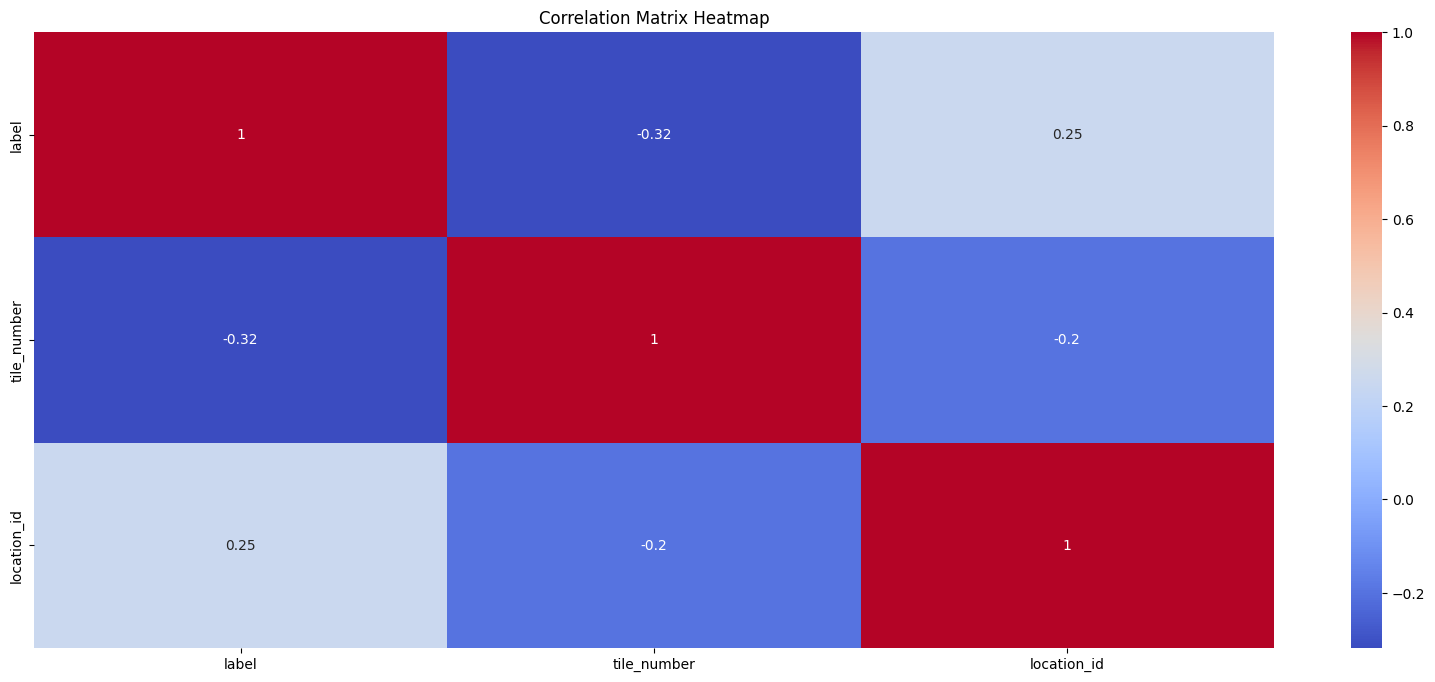

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ... (Your previous code to load and clean the data) ...

# Before calling `corr()`, extract numerical features from the DataFrame
numerical_features = flood.select_dtypes(include=np.number).columns
numerical_data = flood[numerical_features]

# Now calculate the correlation matrix using only numerical features
plt.figure(figsize=(20, 8))
sns.heatmap(numerical_data.corr(), cmap='coolwarm', annot=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [97]:
# Train Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [98]:
#Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train, y_train)

RandomForestRegressor()

In [99]:
y_pred = rf.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

print('R2 Score :', r2_score(y_test, y_pred))
print('Mean Squared Error :', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error :', np.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score : 1.0
Mean Squared Error : 0.0
Root Mean Squared Error : 0.0


In [100]:
#Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [101]:
y_pred = dt.predict(X_test)

print('R2 Score :', r2_score(y_test, y_pred))
print('Mean Squared Error :', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error :', np.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score : 1.0
Mean Squared Error : 0.0
Root Mean Squared Error : 0.0


In [102]:
#Linear Regression

from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg.fit(X_train, y_train)

LinearRegression()

In [103]:
y_pred = linreg.predict(X_test)

print('R2 Score :', r2_score(y_test, y_pred))
print('Mean Squared Error :', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error :', np.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score : 1.0
Mean Squared Error : 2.7259113940850446e-30
Root Mean Squared Error : 1.6510334321524337e-15


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# ... (Load and preprocess data as before) ...

# Build CNN model
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    # Adjust pool_size or padding to avoid negative dimension
    MaxPooling1D(pool_size=1),  # Changed pool_size to 1
    # Alternatively, you could use padding='same' to keep the output dimension the same
    # MaxPooling1D(pool_size=2, padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

# ... (Compile and train the model as before) ...

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [113]:
from sklearn.model_selection import cross_val_score

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier  # Import KNeighborsClassifier

# Assuming 'X' and 'y' are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Split the data

clf = KNeighborsClassifier()  # Create a KNeighborsClassifier object
knn_clf = clf.fit(X_train, y_train) # Fit the model using X_train and y_train

In [118]:
#Let's predict chances of flood
y_predict = knn_clf.predict(X_test) # Changed x_test to X_test
print('predicted chances of flood')
print(y_predict)

predicted chances of flood
[0 1 0 ... 0 1 0]


In [119]:
#Actual chances of flood
print("actual values of floods:")
print(y_test)

actual values of floods:
1168    0
765     1
465     0
1117    0
1599    0
       ..
2503    1
2678    0
1639    0
650     1
1128    0
Name: label, Length: 1671, dtype: int64


In [121]:

from sklearn.model_selection import cross_val_score

In [123]:
from sklearn import model_selection

# Replace 'x_test' with 'X_test'
knn_accuracy = model_selection.cross_val_score(knn_clf, X_test, y_test, cv=3, scoring='accuracy', n_jobs=-1)

In [124]:
knn_accuracy.mean()

0.8617594254937164

In [128]:
from sklearn.preprocessing import MinMaxScaler # Import the MinMaxScaler

# Create an instance of MinMaxScaler
minmax = MinMaxScaler()

# Now you can use it for scaling
# Use X_train and X_test instead of x_train and x_test
X_train_std = minmax.fit_transform(X_train)
X_test_std = minmax.transform(X_test)

In [130]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
# Use X_train_std instead of x_train_std
lr_clf = lr.fit(X_train_std,y_train)

# Use X_test_std instead of x_test_std
lr_accuracy = cross_val_score(lr_clf,X_test_std,y_test,cv=3,scoring='accuracy',n_jobs=-1)

In [131]:
lr_accuracy.mean()

1.0

In [133]:
y_predict = lr_clf.predict(X_test_std) # Change x_test_std to X_test_std
print('Predicted chances of flood')
print(y_predict)

Predicted chances of flood
[0 1 0 ... 0 1 0]


In [134]:

print('Actual chances of flood')
print(y_test.values)

Actual chances of flood
[0 1 0 ... 0 1 0]


In [136]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix

# Convert 'YES' to 1 and 'NO' to 0
y_test_numeric = np.where(y_test == 'YES', 1, 0)
y_predict_numeric = np.where(y_predict == 'YES', 1, 0)

print("\naccuracy score: %f" % (accuracy_score(y_test_numeric, y_predict_numeric) * 100))
print("recall score: %f" % (recall_score(y_test_numeric, y_predict_numeric, pos_label=1) * 100))
print("roc score: %f" % (roc_auc_score(y_test_numeric, y_predict_numeric) * 100))



accuracy score: 100.000000
recall score: 0.000000
roc score: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [138]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

# Assuming you already have your features (X) and labels (y)
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)

# Initialize and fit the DecisionTreeClassifier
dtc_clf = DecisionTreeClassifier()
dtc_clf.fit(x_train_std, y_train)

# Cross-validation with accuracy score
dtc_clf_acc = cross_val_score(dtc_clf, x_train_std, y_train, cv=3, scoring="accuracy", n_jobs=-1)
print(dtc_clf_acc)


[1. 1. 1.]


In [139]:
#Predicted flood chances
y_pred = dtc_clf.predict(x_test)
print(y_pred)

[0 1 0 ... 1 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [140]:
#Actual flood chances
print("actual values:")
print(y_test.values)

actual values:
[0 1 0 ... 1 0 0]


In [142]:
from sklearn.metrics import accuracy_score, recall_score

# Convert 'YES' to 1 and 'NO' to 0 for both y_test and y_pred
y_test_numeric = np.where(y_test == 'YES', 1, 0)
y_pred_numeric = np.where(y_pred == 'YES', 1, 0)

# Calculate the accuracy score
accuracy = accuracy_score(y_test_numeric, y_pred_numeric)
print("Accuracy score: %f" % (accuracy * 100))

# Calculate the recall score
recall = recall_score(y_test_numeric, y_pred_numeric, pos_label=1)
print("Recall score for 'YES': %f" % (recall * 100))


Accuracy score: 100.000000
Recall score for 'YES': 0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [143]:
from sklearn.ensemble import RandomForestClassifier
rmf = RandomForestClassifier(max_depth=3,random_state=0)
rmf_clf = rmf.fit(x_train,y_train)
rmf_clf

RandomForestClassifier(max_depth=3, random_state=0)

In [146]:
from sklearn.model_selection import cross_val_predict


In [147]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier

# Assuming rmf_clf is a RandomForestClassifier or another classifier
rmf_clf = RandomForestClassifier()

# Cross-validation for accuracy score
rmf_clf_acc = cross_val_score(rmf_clf, x_train_std, y_train, cv=3, scoring="accuracy", n_jobs=-1)

# Cross-validation for predicted probabilities
rmf_proba = cross_val_predict(rmf_clf, x_train_std, y_train, cv=3, method='predict_proba')

# Print results
print("Accuracy scores:", rmf_clf_acc)
print("Predicted probabilities:", rmf_proba)


Accuracy scores: [1. 1. 1.]
Predicted probabilities: [[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [148]:
rmf_clf_acc

array([1., 1., 1.])

In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X and y are your features and labels
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)

# Initialize the Random Forest Classifier
rmf_clf = RandomForestClassifier()

# Fit the model
rmf_clf.fit(x_train_std, y_train)

# Make predictions
y_pred = rmf_clf.predict(x_test_std)

# Output predictions
print(y_pred)


[0 1 0 ... 1 0 0]


In [152]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
knn_clf = KNeighborsClassifier()

voting = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('knn', knn_clf)],
    voting='hard')

In [153]:

voting_clf = voting.fit(x_train, y_train)

In [154]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, knn_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 1.0
RandomForestClassifier 1.0
KNeighborsClassifier 0.973967684021544
VotingClassifier 1.0


In [155]:
models = []
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
models.append(('KNN', KNeighborsClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('EL', VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('knn', knn_clf)],
    voting='hard')))


names = []
scores = []
for name, model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)


  Name     Score
0  KNN  0.973968
1   LR  1.000000
2   DT  1.000000
3   RF  1.000000
4   EL  1.000000


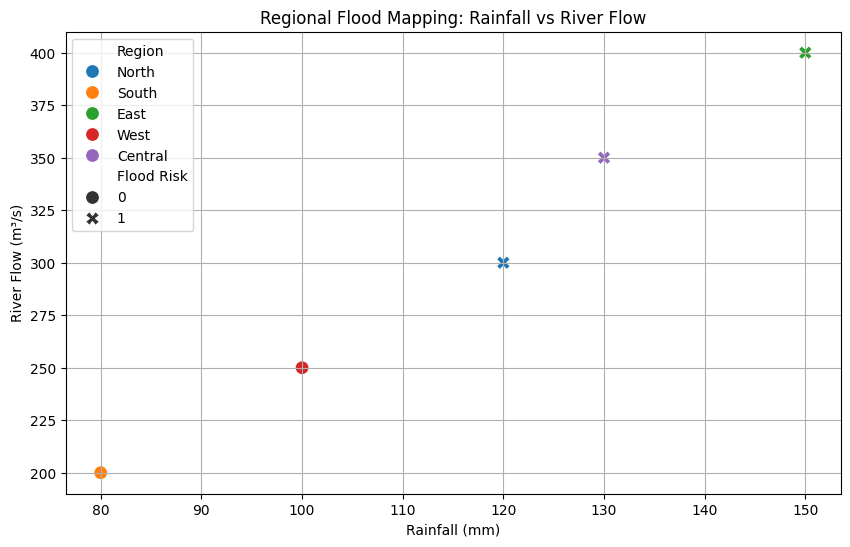

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example dataset
data = {
    'Region': ['North', 'South', 'East', 'West', 'Central'],
    'Rainfall (mm)': [120, 80, 150, 100, 130],
    'River Flow (m³/s)': [300, 200, 400, 250, 350],
    'Flood Risk': [1, 0, 1, 0, 1]  # 1 indicates high risk, 0 indicates low risk
}

df = pd.DataFrame(data)

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rainfall (mm)', y='River Flow (m³/s)', hue='Region', style='Flood Risk', data=df, s=100)
plt.title('Regional Flood Mapping: Rainfall vs River Flow')
plt.xlabel('Rainfall (mm)')
plt.ylabel('River Flow (m³/s)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


RNN MODEL


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical

# Load and preprocess data
s1data = pd.read_csv('/content/s1_data (2).csv', dtype={'folder': 'str'})
s2data = pd.read_csv('/content/s2_data (2).csv', dtype={'folder': 'str'})

data = pd.concat([s1data, s2data], axis=0).dropna()  # Combine and drop missing values

# --- The fix is below ---
# Select only numerical features for scaling, excluding the 'geometry' column
numerical_features = data.select_dtypes(include=np.number).columns
X = data[numerical_features]
# --- End of fix ---

y = data['label']

# Encode target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for RNN input
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build RNN model
rnn_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train RNN model
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate RNN
rnn_accuracy = rnn_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"RNN Accuracy: {rnn_accuracy * 100:.2f}%")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9082 - loss: 0.4952 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 6.6747e-04
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 7.4867e-04 - val_accuracy: 1.0000 - val_loss: 2.4090e-04
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 3.1160e-04 - val_accuracy: 1.0000 - val_loss: 1.1745e-04
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 1.8762e-04 - val_accuracy: 1.0000 - val_loss: 6.6393e-05
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.0950e-04 - val_accuracy: 1.0000 - val_loss: 4.2031e-05
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 7.7481e-05 - val_accuracy: 1.0000 - val_loss: 2.8778e-05
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 